In [1]:
from dolfinx import fem, mesh
from mpi4py import MPI
from petsc4py.PETSc import ScalarType 
from ufl import (TrialFunction, Measure, TestFunction, dx, ds, grad, inner, lhs, rhs)

import timeit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
class BoundaryCondition():
    def __init__(self, type, marker, values, V, v, measure):
        ds = measure['Measure']
        fdim, facets, facet_tag = measure['Facets']
        
        self._type = type
        if type == "Dirichlet":
            u_D = fem.Function(V)
            u_D.interpolate(values)
            facets = facet_tag.find(marker)            
            dofs = fem.locate_dofs_topological(V, fdim, facets)
            self._bc = fem.dirichletbc(u_D, dofs)
        elif type == "Neumann":
                self._bc = inner(values, v) * ds(marker)
        elif type == "Robin":
            self._bc = values[0] * inner(u-values[1], v)* ds(marker)
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(type))
    @property
    def bc(self):
        return self._bc

    @property
    def type(self):
        return self._type

In [3]:
def generate_boundary_measure(domain, points):
    boundaries = [(1, lambda x: np.isclose(x[0], points[0])),
                  (2, lambda x: np.isclose(x[0], points[1]))]
    
    facet_indices, facet_markers = [], []
    fdim = domain.topology.dim - 1
    for (marker, locator) in boundaries:
        facets = mesh.locate_entities(domain, fdim, locator)
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

    ds = Measure("ds", domain=domain, subdomain_data=facet_tag)
    
    return {
        'Measure': ds,
        'Facets': (fdim, facets, facet_tag)
    }

In [4]:
def validate_domains(domains):
    """
    domains = [(points: list[float, float], fluid: str), ...]
    """
    
    for i in range(len(domains)):
        if domains[i][0][1] < domains[i][0][0]:
            raise ValueError(f"Left boundary should be less then right for {domains[i][1]}")
    
    for i in range(1, len(domains)):
        if not np.isclose(domains[i-1][0][1], domains[i][0][0]):
            raise ValueError(f"{domains[i-1][1]} and {domains[i][1]} don't have the same right-left boundary")

In [5]:
def problem_setup(N: int,
                  domains, 
                  freq: float, 
                  pressure: float):
    """
    Performs problem configuration w.r.t. given parameters
    """
    
    validate_domains(domains)
    points = [domains[0][0][0], domains[-1][0][1]]
    
    # Mesh and function space definition
    domain = mesh.create_interval(MPI.COMM_WORLD, N, points)
    V = fem.FunctionSpace(domain, ("CG", 1))

    u = TrialFunction(V)
    v = TestFunction(V)
    
    # Definition of density and speed functions
    ro = fem.Function(V)
    c = fem.Function(V)
    
    cells = list()
    for i in range(len(domains)):
        a, b = domains[i][0]        
        cells.append(mesh.locate_entities(
             domain,
             domain.topology.dim, 
             lambda x: np.logical_and(np.greater_equal(x[0], a),
                                      np.less_equal(x[0], b))))
                             
    for i in range(len(domains)):
        cell = cells[i]
        fluid = domains[i][1]
        density, speed = fluids.loc[fluid, ['Density', 'Speed of sound']]
        
        ro.x.array[cell] = np.full_like(cell, density, dtype=ScalarType)
        c.x.array[cell] = np.full_like(cell, speed, dtype=ScalarType)
        
    omega = freq * 2 * np.pi
        
    # Construction of bilinear form and linear functional
    aa = ro * c**2 * inner(grad(u), grad(v)) * dx
    mm = ro * inner(u, v) * dx

    F = aa - omega**2 * mm
    
    measure = generate_boundary_measure(domain, points)
    
    u_D = lambda x: x[0] * 0.0
    
    boundary_conditions = [BoundaryCondition("Dirichlet", 1, u_D, V, v, measure), 
                           BoundaryCondition("Neumann", 2, ScalarType(-pressure), V, v, measure)]
    
    bcs = []
    for condition in boundary_conditions:
        if condition.type == "Dirichlet":
            bcs.append(condition.bc)
        else:
            F += condition.bc
    
    Left = lhs(F)
    Right = rhs(F)
    
    return {
        'Params': (N, points, domains, omega, pressure),
        'FunctionSpace': (domain, V, u, v),
        'Problem': (Left, Right, bcs)
    }

#### Available fluids

In [6]:
fluids = pd.read_csv('../data/physical_properties.csv', sep=';', index_col='Fluid')
fluids

,Density,Speed of sound,Viscosity
Fluid,,,
Water,1000,1500,0.000894
Fuel oil,890,1360,2.022000
Oil,760,1470,0.000500


In [7]:
config = problem_setup(N=500, 
                       domains=[([0.0, 5.0], 'Water'),
                                ([5.0, 6.0], 'Fuel oil'),
                                ([6.0, 10.0], 'Water')],
                       freq=1500,
                       pressure=1.0)

N, points, domains, omega, pressure = config['Params']
domain, V, u, v = config['FunctionSpace']
Left, Right, bcs = config['Problem']

In [8]:
problem = fem.petsc.LinearProblem(Left, Right, bcs)
uh = problem.solve()

## Results

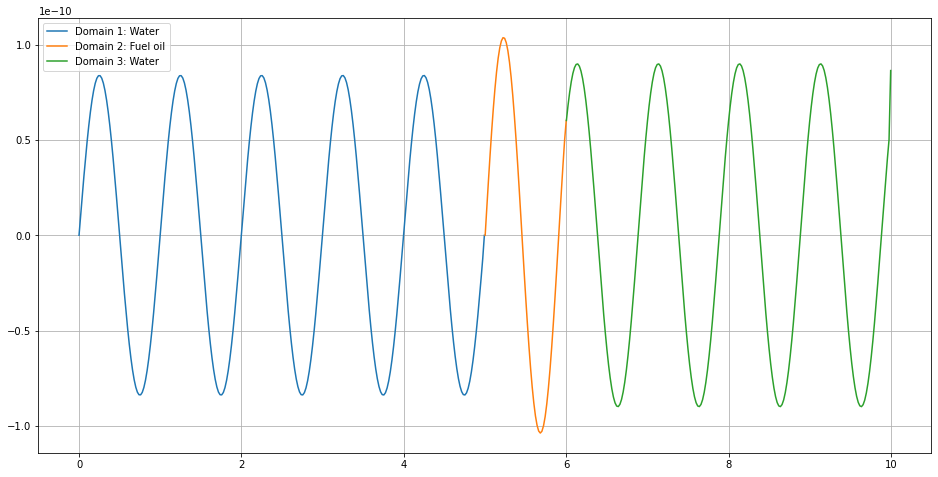

In [9]:
fig, ax = plt.subplots(figsize=(16,8))

for idx, domain in enumerate(domains):
    a, b = domain[0]
    step = (points[1] - points[0]) / uh.vector.array.size
    xs = np.arange(a, b, step)
    sidx = int((a - points[0]) / step)
    eidx = sidx + len(xs)
    
    ax.plot(xs, uh.vector.array[sidx:eidx], label=f'Domain {idx+1}: {domain[1]}')

ax.legend()
ax.grid()

In [10]:
def L2_norm(fun):
    comm = uh.function_space.mesh.comm
    error = fem.form(fun**2 * dx)
    norm = np.sqrt(comm.allreduce(fem.assemble_scalar(error), MPI.SUM))
    
    if comm.rank == 0:
        return norm

## Convergence

In [11]:
def calc_convergence(rounds: int = 5):
    """
    Convergence calculation
    """
    
    results = list()
    for i in range(rounds):
        config = problem_setup(N=50 * 2**i, 
                       domains=[([0.0, 5.0], 'Water'),
                                ([5.0, 6.0], 'Fuel oil'),
                                ([6.0, 10.0], 'Water')],
                       freq=1500,
                       pressure=1.0)

        N, points, domains, omega, pressure = config['Params']
        domain, V, u, v = config['FunctionSpace']
        Left, Right, bcs = config['Problem']
        
        problem = fem.petsc.LinearProblem(Left, Right, bcs)
        
        start = timeit.default_timer()
        uh = problem.solve()
        stop = timeit.default_timer()
        
        # u_ex = fem.Function(V)
        # u_ex.interpolate(u_exact)
        
        norm_l2_uh = L2_norm(uh)
        # error = L2_error(uh, u_ex)
        
        results.append([50 * 2**i, norm_l2_uh, np.nan, np.nan, stop - start])
                  
        if len(results) > 1:
            results[-1][2] = abs(results[-2][1] - results[-1][1])
            
        if len(results) > 2:
            results[-1][3] = np.log2((results[-3][2] - results[-2][2])/(results[-2][2] - results[-1][2]))
        
    return results

In [12]:
cdata = calc_convergence(12)
cdf = pd.DataFrame(cdata, columns=['N', '||u_h||', 'error', 'k', 'time']).set_index('N')
cdf

,||u_h||,error,k,time
N,,,,
50,3.274727e-10,NaN,NaN,0.000323
100,2.490189e-10,7.845379e-11,NaN,0.001064
200,1.785258e-10,7.049308e-11,NaN,0.000451
400,1.930698e-10,1.454396e-11,-2.813146,0.000552
800,2.023129e-10,9.243135e-12,3.399826,0.000684
1600,2.064234e-10,4.110505e-12,0.046519,0.001043
3200,2.082294e-10,1.806037e-12,1.155264,0.001526
6400,2.090566e-10,8.271264e-13,1.235184,0.002843
12800,2.094496e-10,3.930492e-13,1.173226,0.005343
